### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib
%matplotlib inline
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


### Constants

In [2]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'
POPULATION_FILE = 'population.csv'
IHD_FILE = 'ihd.csv'
JSON_COUNTRIES_FILE = 'world-countries.json'
COUNTRIES_CONTINENTS = 'countries_continents.csv'

### Read Data

In [3]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)
ihd = pd.read_csv(DATA_FOLDER + '/' + IHD_FILE, low_memory=False)
population = pd.read_csv(DATA_FOLDER + '/' + POPULATION_FILE, low_memory=False)
countries_shapes = pd.read_json(DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, orient='columns')
countries_continents = pd.read_csv(DATA_FOLDER + '/' + COUNTRIES_CONTINENTS, low_memory=False, index_col='Code')

### Analyse the different datasets

### Open Food Facts 

In [4]:
food_data = all_datas.copy()
food_data.shape

(685395, 173)

We can see that open food facts has 173 features. This is a lot of information!
We have to select only the features which could help us to answer our questions. 
We would like to see the number of entries per features, to see which would have enough samples for our data, once all NaN values of a row are dropped.

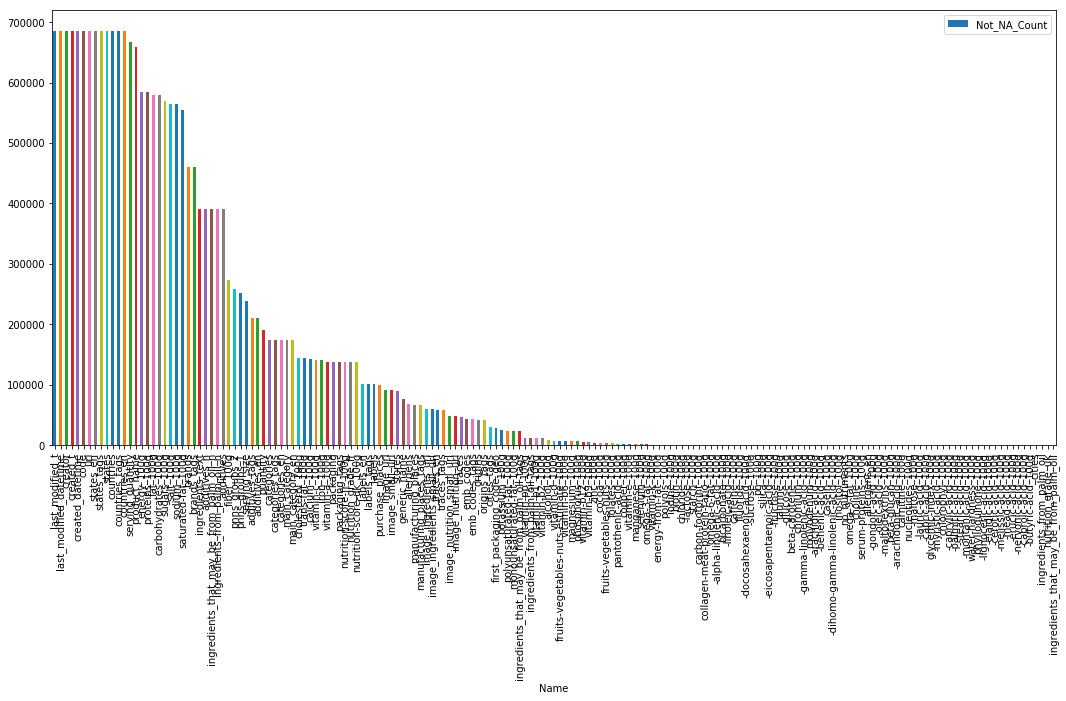

In [5]:
not_na = []
#for each feature in our dataset
for c in food_data.columns.values: 
    #count na values per feature
    count = food_data[c].notna().sum()
    not_na.append((c, count))
#create df with feature name and number of valid entries
df = pd.DataFrame(not_na, columns=['Name','Not_NA_Count'])
#sort
df.sort_values(by='Not_NA_Count', inplace=True, ascending=False)
df = df.reset_index(drop=True)
#plot
df.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,8))

We can see that although there are many available features, over half of them have a very small amount of entries. 

Let's plot a graph with a threshold on the amount of entries, i.e. 10000

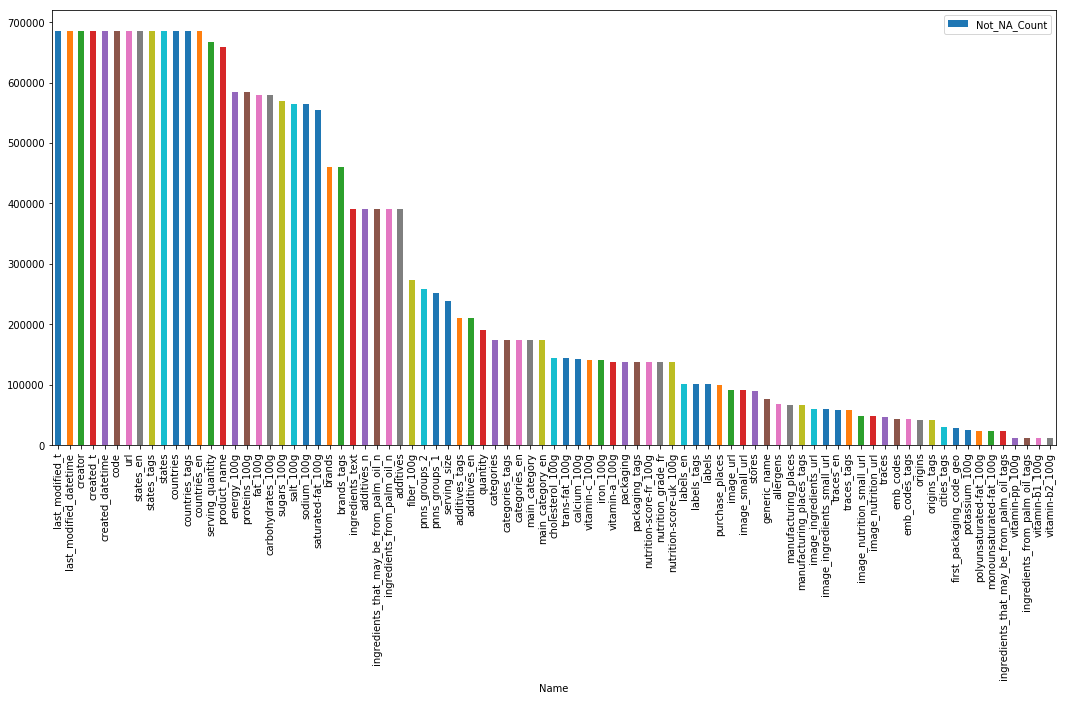

In [6]:
threshold = 10000
df[df['Not_NA_Count'] > threshold].plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,8))

This is already better, but we can see that there are a lot of features that are not useful to us (i.e. last_modified_t, creator, url, states, ...). 

We have thus selected features that we judge will be interesting to look at later on in our study

In [7]:
features = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g',
            'energy_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g',
            'saturated-fat_100g','ingredients_text', 'fiber_100g','serving_size', 'additives_en']

In [8]:
food_data[features].dropna().shape

(98828, 15)

If we drop all rows with NaN values, we still have a sample of 98828 entries, which we judge to be sufficient.

Features that will be useful to our study:
 - product_name: name of product
 - countries/countries_tags:  list of countries where the product is sold
 - sugars_100g, fat_100g, energy_100g, carbohydrates_100g, proteins_100g, salt_100g, sodium_100g , saturated-fat_100g, fiber_100g: the amount of a nutriment (in g, or kJ for energy) for 100 g
 - ingredients_text: ingredients contained in the product
 - additives_en: additives found in the product


We have spotted that there will be some work to do in order to group products by countries, since some products are sold in many countries. The countries_tags consist of a list of countries, with a language tag followed by the country name (in said language).
For example:

In [9]:
food_data['countries_tags'].value_counts()[150:160]

en:france,en:portugal,en:spain               25
en:belgium,en:switzerland                    24
en:france,en:united-arab-emirates            24
en:france,en:spain,en:switzerland            24
en:france,en:switzerland,en:united-states    24
en:france,en:germany,en:en                   23
en:poland,en:united-kingdom                  23
en:latvia                                    23
en:france,en:india                           22
en:france,en:mexico                          22
Name: countries_tags, dtype: int64

This is why we have a dataset associating country names (in different languages) with their alpha codes.

### Countries

As stated above, this dataset associates a country name in a certain language, with the language tag, the alpha 2/3 code and the numeric code. 
We will use it to group the countries of the food data together.

In [10]:
countries_infos.shape

(20169, 6)

In [11]:
countries_infos.head()

LANG  LANG_NAME COUNTRY_ALPHA2_CODE COUNTRY_ALPHA3_CODE  \
0   AF  AFRIKAANS                  AD                 AND   
1   AF  AFRIKAANS                  AE                 ARE   
2   AF  AFRIKAANS                  AF                 AFG   
3   AF  AFRIKAANS                  AG                 ATG   
4   AF  AFRIKAANS                  AI                 AIA   

   COUNTRY_NUMERIC_CODE                COUNTRY_NAME  
0                    20                     Andorra  
1                   784  Verenigde Arabiese Emirate  
2                     4                  Afganistan  
3                    28          Antigua en Barbuda  
4                   660                    Anguilla

### Countries/Continents
Association of countries (alpha 2 code) with their continent code
[https://dev.maxmind.com/geoip/legacy/codes/country_continent/]

In [12]:
countries_continents.head()

Continent
Code          
AD          EU
AE          AS
AF          AS
AG         NaN
AI         NaN

### Countries Shapes
Json file associating a country with its border coordinates. 
This will be used to display maps.
Example:
```json
{
    "type":"Feature",
    "properties":{"name":"Afghanistan"},
    "geometry":{"type":"Polygon","coordinates":[[[61.210817,35.650072],...,[61.210817,35.650072]]]},
    "id":"AFG"
}
```

### Overweight
This data indicates the population percentage which is overweight, for a certain country and by year.

We choose to work only with the last year of the database (2016).

In [13]:
overweight.shape

(8022, 4)

In [14]:
overweight.head()

Entity Code  Year  Indicator
0  Afghanistan  AFG  1975        0.5
1  Afghanistan  AFG  1976        0.5
2  Afghanistan  AFG  1977        0.6
3  Afghanistan  AFG  1978        0.6
4  Afghanistan  AFG  1979        0.6

###  Diabetes
Prevalence of diabetes per category and per country for the year 2017.
We will only look at the country/territory and Diabetes [18-99] national prevalence[%]

In [15]:
diabetes.shape

(221, 23)

In [16]:
diabetes.head()

country_id country/territory idf_reg  \
0           1       Afghanistan    MENA   
1           2           Albania     EUR   
2           3           Algeria    MENA   
3           4           Andorra     EUR   
4           5            Angola     AFR   

   Adults with diabetes[18-99] in 1,000s      prev  Unnamed: 5  \
0                            1054.460430  0.061482         NaN   
1                             267.266724  0.119302         NaN   
2                            1884.558775  0.068824         NaN   
3                               7.219999  0.127023         NaN   
4                             359.075986  0.029196         NaN   

   Adults with diabetes confidence interval in 1,000s Min  \
0                                         840.613890        
1                                         232.694171        
2                                        1247.936183        
3                                           6.118940        
4                                         217.039437        

   Adults with diabetes confidence interval in 1,000s Max  \
0                                        1494.825185        
1                                         304.292989        
2                                        2629.709395        
3                                           9.315789        
4                                         576.950839        

  Diabetes [18-99] national prevalence[%]  \
0                                   6.15%   
1                                  11.93%   
2                                   6.88%   
3                                  12.70%   
4                                   2.92%   

  Diabetes National prevalence confidence interval Min   \
0                                              4.90%      
1                                             10.39%      
2                                              4.56%      
3                                             10.77%      
4                                              1.76%      

                                       ...                                       \
0                                      ...                                        
1                                      ...                                        
2                                      ...                                        
3                                      ...                                        
4                                      ...                                        

  Diabetes age-adjusted comparative prevalence confidence interval  Max  \
0                                             13.80%                      
1                                             11.29%                      
2                                              9.34%                      
3                                             10.71%                      
4                                              5.86%                      

  Undiagnosed diabetes [18-99] in 1,000  \
0                            733.870351   
1                            108.610335   
2                           1239.097394   
3                              2.581379   
4                            178.444879   

  Undiagnosed diabetes confidence interval Min  \
0                                   585.040076   
1                                    94.560937   
2                                   820.518040   
3                                     2.187715   
4                                   107.858998   

  Undiagnosed diabetes confidence interval Max  \
0                                  1040.349976   
1                                   123.656858   
2                                  1729.033927   
3                                     3.330690   
4                                   286.719042   

   Mean Expenditure per person with diabetes (18-99) USD  \
0                                              115.0       
1                                              369.0    

### Ischaemic  Heart   Disease
Number of deaths (in thousands) of IHD per country, for the year 2008. 
It was really hard to find official medical data, so even it is a decade ago, we are still interested in the trend. 

In [17]:
ihd.shape

(174, 2)

In [18]:
ihd.head()

Country    IHD
0             USA  445.8
1         Germany  155.8
2           Japan  105.5
3  United Kingdom   92.3
4           Italy   87.8

### Population
Country population for the year 2008. 

In [19]:
population.shape

(236, 2)

In [20]:
population.head()

Country  Population
0           China  1321851888
1           India  1129866154
2  European Union   490426060
3   United States   301139947
4       Indonesia   234693997

### Data Cleaning

We do some operations on the countries tags to be able to parse the data. 

We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics!

In [21]:
#select only relevant features for the countries infos
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME', 'COUNTRY_ALPHA3_CODE']]
#merge with the countries continents in order to have the continents tag too
countries_infos = countries_infos.merge(countries_continents, left_on='COUNTRY_ALPHA2_CODE', right_index=True)
#fix bug - north america continent tag was set as NaN.
countries_infos['Continent'] = countries_infos['Continent'].replace(np.nan, 'NA', regex=True)

In [22]:
#select only relevant features
food_data = food_data[features]
#remove language tags from countries_tags and countries
food_data['countries_tags'] = food_data['countries_tags'].replace(regex=True, to_replace=r'\w\w:', value=r'')
food_data['countries'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
#make country names lower case
food_data['countries'] = food_data['countries'].apply(lambda x: str(x).lower())
#filter outliers
to_filter = ['sugars_100g','fat_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g',
            'saturated-fat_100g', 'fiber_100g']
for i in to_filter:
    food_data = food_data[food_data[i] <= 100]

In [23]:
#get a feeling of the data
food_data.head()

product_name countries countries_tags  sugars_100g  fat_100g  \
10  Solène céréales poulet    france         france          1.7       5.9   
11      Tarte noix de coco    france         france         21.9      22.0   
17        Compote de poire    france         france         27.0       0.0   
22       Baguette Poitevin    france         france          0.6       6.7   
31          Suedois saumon    france         france          4.6       4.4   

    energy_100g  carbohydrates_100g  proteins_100g  salt_100g  sodium_100g  \
10        916.0                30.3            9.7      0.464     0.182677   
11       1594.0                27.3            4.6      0.100     0.039370   
17        657.0                36.0            0.6      0.000     0.000000   
22        866.0                27.5            8.9      0.400     0.157480   
31        720.0                23.3            8.4      3.580     1.409449   

    saturated-fat_100g                                   ingredients_text  \
10                 0.5  antioxydant : érythorbate de sodium, colorant ...   
11                15.5                                                NaN   
17                 0.0                                                NaN   
22                 3.8  baguette Poite vin Pain baguette 50,6%: fqrine...   
31                 1.2  Paln suédois 42,6%: farine de BLÉ, eau, farine...   

    fiber_100g serving_size                                       additives_en  
10         2.8          NaN  E150 - Caramel,E160a - Alpha-carotene,E202 - P...  
11         4.4          NaN                                                NaN  
17         3.6          NaN                                                NaN  
22         1.7          NaN                                                NaN  
31         2.7          NaN    E300 - Ascorbic acid,E503 - Ammonium carbonates

We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [24]:
countries = []

for c in food_data['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.lower()
        #check if any language tags are left over
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name,  country code and continent
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE'], c_i['COUNTRY_ALPHA3_CODE'], c_i['Continent']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???", "???", "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [25]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)

In [26]:
#we saw that a few countries were not added, it must be something related to our above code or the dataset. 
#since there were only a few, we decided to add them by hand
to_append = [('united-states', 'US', 'USA','NA'), ('united-kingdom', 'GB', 'GBR', 'EU'), 
             ('french-polynesia', 'PF', 'PYF','OC'),
             ('hong-kong', 'HK', 'HKG','AS'), ('new-zealand', 'NZ','NZL', 'OC'), ('new-caledonia', 'NC', 'NCL', 'OC'),
             ('scotland','GB', 'GBR' ,'EU'), ('united-arab-emirates', 'AE', 'ARE', 'AS'), ('etats-unis', 'US', 'USA', 'NA'),
             ('czech-republic', 'CZ', 'CZE','EU'), ('south-africa', 'ZA', 'ZAF','AF'), ('quebec', 'CA', 'CAN','NA'), 
             ('south-korea', 'KR', 'KOR', 'AS'), ('united-states-of-america','US', 'USA', 'NA'), 
             ('russian-federation', 'RU', 'RUS', 'EU'), ('republic-of-korea','KR', 'KOR', 'AS'), 
             ('hong-kong-china', 'HK', 'HKG','AS'), 
             ('us', 'US', 'USA','NA'), ('usa', 'US', 'USA','NA')]
for i in to_append:
    proper_countries.append(i)

In [27]:
proper_countries[0:10]

[('france', 'FR', 'FRA', 'EU'),
 ('canada', 'CA', 'CAN', 'NA'),
 ('oman', 'OM', 'OMN', 'AS'),
 ('germany', 'DE', 'DEU', 'EU'),
 ('belgium', 'BE', 'BEL', 'EU'),
 ('netherlands', 'NL', 'NLD', 'EU'),
 ('switzerland', 'CH', 'CHE', 'EU'),
 ('mexico', 'MX', 'MEX', 'NA'),
 ('italy', 'IT', 'ITA', 'EU'),
 ('australia', 'AU', 'AUS', 'OC')]

When a rows mention many countries we explode the dataframe to get one line for each country.

In [28]:
def explode(df):
    rows = []
    #for each row
    for index, data in df.iterrows():
        #split the countries by the comma
        countries = str(data['countries_tags']).split(',')
        #for each country
        for country in countries:
            #replace data with country
            data['countries'] = country
            #add row to dataset
            rows.append(data)
    #create new dataframe with our exploded data
    return pd.DataFrame(rows)

In [29]:
exploded_data = explode(food_data)

Get country aplha 2 code, alpha 3 code and continent for each row

In [30]:
exploded_data.head()

product_name countries countries_tags  sugars_100g  fat_100g  \
10  Solène céréales poulet    france         france          1.7       5.9   
11      Tarte noix de coco    france         france         21.9      22.0   
17        Compote de poire    france         france         27.0       0.0   
22       Baguette Poitevin    france         france          0.6       6.7   
31          Suedois saumon    france         france          4.6       4.4   

    energy_100g  carbohydrates_100g  proteins_100g  salt_100g  sodium_100g  \
10        916.0                30.3            9.7      0.464     0.182677   
11       1594.0                27.3            4.6      0.100     0.039370   
17        657.0                36.0            0.6      0.000     0.000000   
22        866.0                27.5            8.9      0.400     0.157480   
31        720.0                23.3            8.4      3.580     1.409449   

    saturated-fat_100g                                   ingredients_text  \
10                 0.5  antioxydant : érythorbate de sodium, colorant ...   
11                15.5                                                NaN   
17                 0.0                                                NaN   
22                 3.8  baguette Poite vin Pain baguette 50,6%: fqrine...   
31                 1.2  Paln suédois 42,6%: farine de BLÉ, eau, farine...   

    fiber_100g serving_size                                       additives_en  
10         2.8          NaN  E150 - Caramel,E160a - Alpha-carotene,E202 - P...  
11         4.4          NaN                                                NaN  
17         3.6          NaN                                                NaN  
22         1.7          NaN                                                NaN  
31         2.7          NaN    E300 - Ascorbic acid,E503 - Ammonium carbonates

In [31]:
#parsed_datas = exploded_data.merge(how='outer',country_codes_continent, left_on='countries_tags', right_on='country')
#parsed_datas['alpha2'].value_counts()

In [32]:
def get_tag(row, col1, col2, col3='alpha3', col4='continent'):
    #for each country
    for c in proper_countries:
        #if the country is found in proper countries
        if c[0] == row[col1]:
            #set the value of col2 to the country alpha 2 code
            row[col2] = c[1]
            #set the value of col3 to the country alpha 3 code
            row[col3] = c[2]
            #set the value of col4 to the continent
            row[col4] = c[3]
            return row
    #if nothing was found, we return TBD
    row[col2] = "TBD"
    row[col3] = "TBD"
    row[col4] = "TBD"
    return row

In [33]:
exploded_data['continent'] = ''
exploded_data['alpha3'] = ''
parsed_datas = exploded_data.apply(lambda x: get_tag(x, 'countries', 'countries_tags', 'alpha3', 'continent'), axis=1)


In [34]:
parsed_datas = parsed_datas.reset_index(drop=True)
parsed_datas.head()

product_name countries countries_tags  sugars_100g  fat_100g  \
0  Solène céréales poulet    france             FR          1.7       5.9   
1      Tarte noix de coco    france             FR         21.9      22.0   
2        Compote de poire    france             FR         27.0       0.0   
3       Baguette Poitevin    france             FR          0.6       6.7   
4          Suedois saumon    france             FR          4.6       4.4   

   energy_100g  carbohydrates_100g  proteins_100g  salt_100g  sodium_100g  \
0        916.0                30.3            9.7      0.464     0.182677   
1       1594.0                27.3            4.6      0.100     0.039370   
2        657.0                36.0            0.6      0.000     0.000000   
3        866.0                27.5            8.9      0.400     0.157480   
4        720.0                23.3            8.4      3.580     1.409449   

   saturated-fat_100g                                   ingredients_text  \
0                 0.5  antioxydant : érythorbate de sodium, colorant ...   
1                15.5                                                NaN   
2                 0.0                                                NaN   
3                 3.8  baguette Poite vin Pain baguette 50,6%: fqrine...   
4                 1.2  Paln suédois 42,6%: farine de BLÉ, eau, farine...   

   fiber_100g serving_size                                       additives_en  \
0         2.8          NaN  E150 - Caramel,E160a - Alpha-carotene,E202 - P...   
1         4.4          NaN                                                NaN   
2         3.6          NaN                                                NaN   
3         1.7          NaN                                                NaN   
4         2.7          NaN    E300 - Ascorbic acid,E503 - Ammonium carbonates   

  continent alpha3  
0        EU    FRA  
1        EU    FRA  
2        EU    FRA  
3        EU    FRA  
4        EU    FRA

In [35]:
#top 10 countries with entries
parsed_datas['countries_tags'].value_counts()[0:10]

US    136761
FR    101324
CH     12977
DE      4231
GB      4120
ES      3458
MX      1395
IT      1103
BE       958
NL       694
Name: countries_tags, dtype: int64

__Fun fact: Switzerland is the 3rd country with the most entries in the open food facts database!__

### Compute
Now we compute result from the parsed datasets. 
We would like to get the mean and median averages of nutriments_100g per country.
Since the entries per country vary in size and in types of foods, we thought it might be interesting to look at both averages.

In [36]:
grouped = parsed_datas.groupby(['countries_tags'])
mean = grouped.mean()
median = grouped.median()
counted = grouped.count()

### Sets
We define sets by continents to look at correlations later on. Note, antarctica had no entries so we discard it.

In [37]:
asia = parsed_datas[parsed_datas['continent'] == 'AS']
africa = parsed_datas[parsed_datas['continent'] == 'AF']
oceania = parsed_datas[parsed_datas['continent'] == 'OC']
europe = parsed_datas[parsed_datas['continent'] == 'EU']
north_america = parsed_datas[parsed_datas['continent'] == 'NA']
south_america = parsed_datas[parsed_datas['continent'] == 'SA']

In [38]:
def median_mean_grouped(df, group_by):
    grouped = df.groupby([group_by])
    median = grouped.median()
    mean = grouped.mean()
    return median, mean

In [39]:
asia_med, asia_mean = median_mean_grouped(asia, 'countries_tags')
africa_med, africa_mean = median_mean_grouped(africa, 'countries_tags')
oceania_med, oceania_mean = median_mean_grouped(oceania, 'countries_tags')
europe_med, europe_mean = median_mean_grouped(europe, 'countries_tags')
na_med, na_mean = median_mean_grouped(north_america, 'countries_tags')
sa_med, sa_mean = median_mean_grouped(south_america, 'countries_tags')

In [40]:
means = [mean, africa_mean, asia_mean, europe_mean, na_mean, sa_mean, oceania_mean]
medians = [median, africa_med, asia_med, europe_med, na_med, sa_med, oceania_med]
rows = [parsed_datas.shape[0], africa.shape[0], asia.shape[0], europe.shape[0], 
        north_america.shape[0], south_america.shape[0], oceania.shape[0]]
continent = ['ALL', 'AF', 'AS', 'EU', 'NA', 'SA', 'OC']
columns = ['Continent','Pearson', 'P-Value_Pearson','Spearman', 'P-Value_Spearman'
          #'Kendall', 
          ]

In [41]:
#re add continent to means/medians df
for i in range(1,len(means)):
    means[i]['continent'] = continent[i]
    medians[i]['continent'] = continent[i]

### Correlations and Plotting functions

We define various functions to get pretty plots for our data, as well as to get the correlations.

In [42]:
def plot_mean_med(df1, df2):
    f, ax = plt.subplots(nrows=2)
    a = df1.plot.bar(figsize=(15,5), ax=ax[0], title='Mean')
    b = df2.plot.bar(figsize=(15,5), ax=ax[1], title='Median')
    plt.tight_layout()
    plt.show()

In [43]:
def corr(df, x_, y_, continent, avg):
    pearson_coeff = pearsonr(df[x_], df[y_])
    spearman_coeff = spearmanr(df[x_], df[y_])
    return [continent,pearson_coeff[0], pearson_coeff[1], spearman_coeff[0], spearman_coeff[1]]

In [44]:
def plt_corr(df1, df2, continent, avg1, avg2, x_, y_, title_):
    f, ax = plt.subplots(ncols=2, sharey=True)
    a =  df1.plot(kind='scatter',x=x_,y=y_, title= continent + " : " + avg1 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[0])
    b =  df2.plot(kind='scatter',x=x_,y=y_, title=continent + " : " + avg2 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[1])
    plt.tight_layout()
    plt.show()
    corrs_avg1 = corr(df1, x_, y_, continent, avg1)
    corrs_avg2 = corr(df2, x_, y_, continent, avg2)
    return corrs_avg1, corrs_avg2

In [45]:
def plot(dfs_1, dfs_2, continents, avg1, avg2, x_, y_, title_, columns_):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(dfs_1)
    f, ax = plt.subplots(ncols=2, nrows=(nb_rows + 1), figsize=(10, 30))
    for i in range(nb_rows):
        a = dfs_1[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg1 +" : "+ title_, ax=ax[i][0])
        b = dfs_2[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg2 +" : "+ title_, ax=ax[i][1])
        c_1 = corr(dfs_1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs_2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[nb_rows][0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[nb_rows][1], title = 'Correlations : ' + avg2)
    plt.tight_layout()
    plt.show()
    print('Mean')
    display(corr1)
    print('Median')
    display(corr2)


In [46]:
def merge_all(dfs, merge_with, left_on_='countries_tags', right_on_='code', right_index=False):
    merged = []
    for i in dfs:
        if right_index:
            merged.append(i.merge(merge_with, left_on=left_on_, right_index=True))
        else:
            merged.append(i.merge(merge_with, left_on=left_on_, right_on=right_on_))
    return merged

In [47]:
def sns_plt(df1, df2, x_, y_, hue_, avg1, avg2, title_):
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_title(avg1 + " : " + title_)
    ax[1].set_title(avg2 + " : " + title_)
    sns.set(style="ticks", rc={'figure.figsize':(10, 10)})
    sns.scatterplot(x=x_, y=y_, data=df1, hue=hue_, ax=ax[0])
    sns.scatterplot(x=x_, y=y_, data=df2, hue=hue_, ax=ax[1])
    plt.tight_layout()
    plt.show()

In [48]:
def show_corr(dfs1, dfs2, x_, y_, avg1, avg2, columns_, continent):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(dfs1)
    for i in range(nb_rows):
        c_1 = corr(dfs1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    f, ax = plt.subplots(ncols=2, figsize=(15, 8))
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[1], title = 'Correlations : ' + avg2)
    plt.show()
    print('Mean')
    display(corr1)
    print('Median')
    display(corr2)

## Sugar vs. Fat

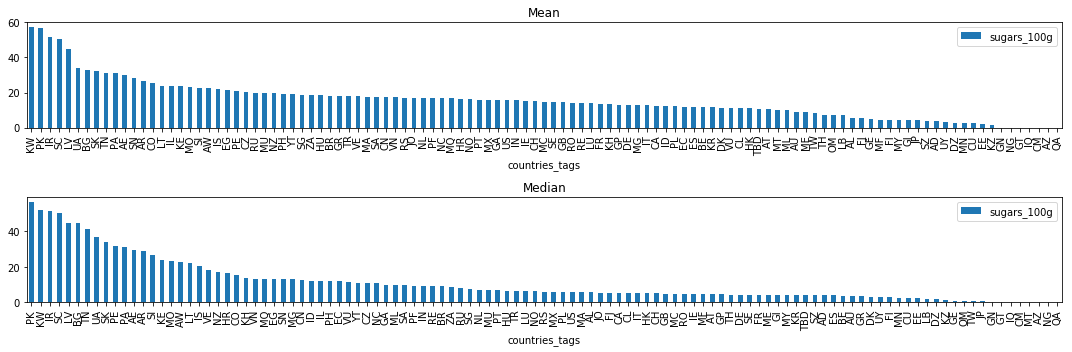

In [49]:
plot_mean_med(pd.DataFrame(mean['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False), 
              pd.DataFrame(median['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False))

Plots of mean and median quantity of sugar per 100g per country

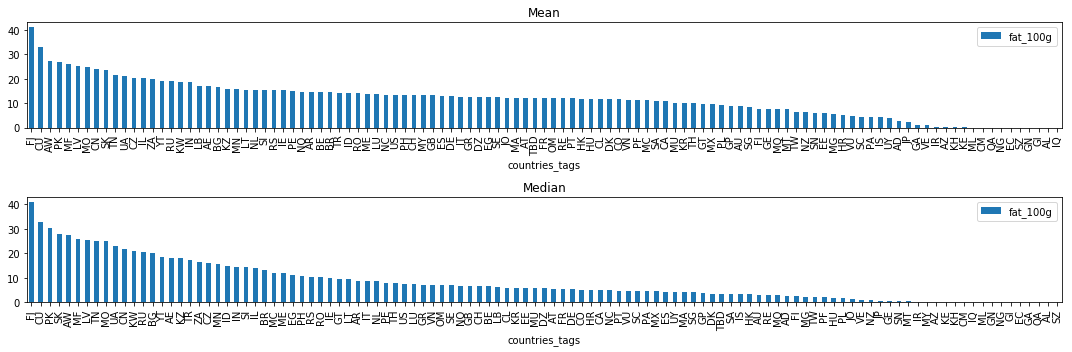

In [50]:
plot_mean_med(pd.DataFrame(mean['fat_100g']).sort_values(by=['fat_100g'], ascending=False), 
              pd.DataFrame(median['fat_100g']).sort_values(by=['fat_100g'], ascending=False))

Plots of mean and median quantity of fat per 100g per country

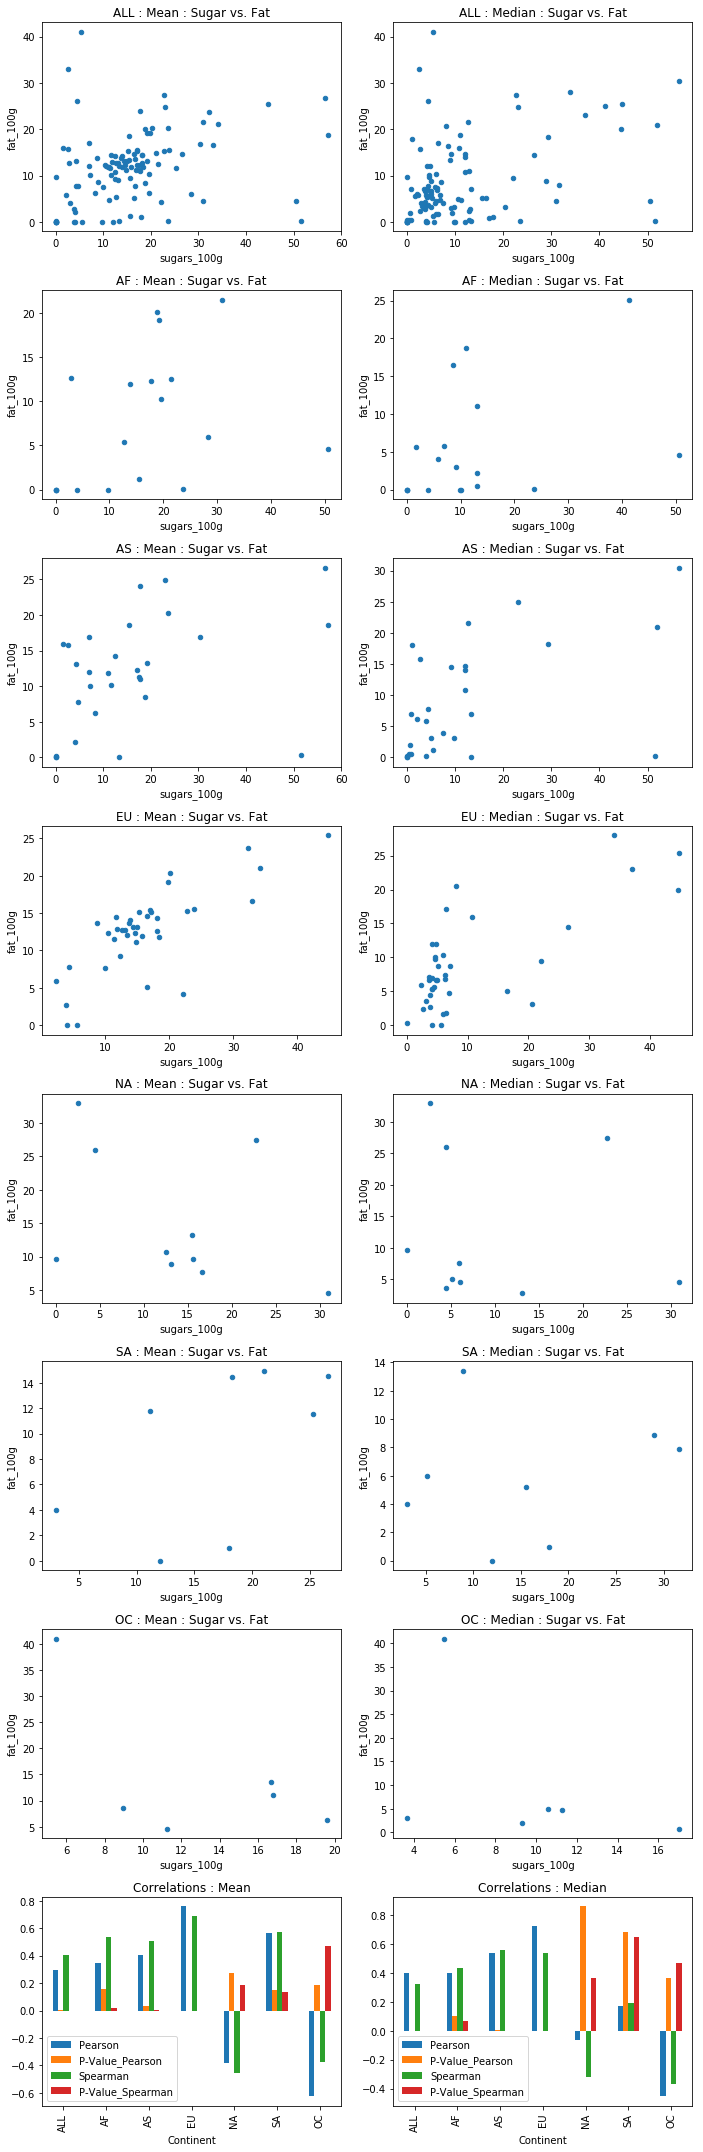

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.296206     1.596492e-03  0.402451          0.000012
1        AF  0.347315     1.579028e-01  0.536069          0.021836
2        AS  0.402714     3.031529e-02  0.505237          0.005181
3        EU  0.759464     2.079363e-08  0.688496          0.000001
4        NA -0.385326     2.714946e-01 -0.454545          0.186905
5        SA  0.562230     1.469050e-01  0.571429          0.138960
6        OC -0.625454     1.841558e-01 -0.371429          0.468478

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.397509     1.560236e-05  0.323181          0.000541
1        AF  0.399091     1.008708e-01  0.438039          0.069037
2        AS  0.539406     2.530605e-03  0.562423          0.001495
3        EU  0.727220     1.574943e-07  0.540639          0.000381
4        NA -0.063446     8.617689e-01 -0.321212          0.365468
5        SA  0.170326     6.867624e-01  0.190476          0.651401
6        OC -0.454511     3.651803e-01 -0.371429          0.468478

In [51]:
plot(means, medians, continent, 'Mean', 'Median', 'sugars_100g', 'fat_100g', 'Sugar vs. Fat', columns)

#### Analysis
For the sugar vs. fat analysis, we have a case of the Simpson's paradox: we can see that the correlation for the mean/median for all continents is around 0.3-0.4, which is not very significant.

When we look at continents on their own, we can see that Europe has a high pearson correlation (0.759 for the mean and 0.727 for the median. The p-value is much smaller than 0.05, so the result is significant.
The spearman correlation is also quite high for the mean (0.688) but not so much for the median (0.54). 
It makes sense when we look at the correlation plot.
For the mean, there is a clear monotonic (always increasing) and a linear relationship. The spearman correlation is also quite strong in this case, thanks to the monotonic relationship.
We can see a strong linear relationship for the two groups in the median, but a weaker monotonic relationship, which explains the weaker spearman correlation.

Asia comes next in line with respect to correlation coefficients, having a moderate positive correlation.
We can spot some linear relationships in both plots, but the outliers influence the monotonicity of the relationship.

In [52]:
display(pd.DataFrame(europe_med['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False).head(3))
display(pd.DataFrame(europe_mean['sugars_100g']).sort_values(by=['sugars_100g'], ascending=False).head(3))

sugars_100g
countries_tags             
LV                     44.7
BG                     44.5
UA                     37.0

sugars_100g
countries_tags             
LV                44.700000
UA                34.191667
BG                32.956667

__Top 3 countries in europe with most suggary foods: Latvia, Bulgaria, Ukraine__

In [53]:
display(pd.DataFrame(europe_med['fat_100g']).sort_values(by=['fat_100g'], ascending=False).head(3))
display(pd.DataFrame(europe_mean['fat_100g']).sort_values(by=['fat_100g'], ascending=False).head(3))

fat_100g
countries_tags          
SK                  28.0
LV                  25.4
UA                  23.0

fat_100g
countries_tags           
LV              25.400000
SK              23.682353
UA              21.041667

__Top 3 countries in europe with most fatty foods: Slovakia, Latvia, Ukraine__

### Overweight

In [54]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: x.lower().replace(' ', '-'))
#get country codes
overweight_datas = overweight_datas.apply(lambda x: get_tag(x, 'Entity', 'Code'), axis=1)
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Code'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Code'])
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)
indices = parsed_datas['countries_tags'].drop_duplicates().values
overweight_datas = overweight_datas[overweight_datas.index.isin(indices)]
overweight_datas = overweight_datas.rename(columns={'Indicator':'Overweight Prevalence'})
overweight_datas.index.name = 'countries_tags'

In [55]:
mean_overweight = merge_all(means, overweight_datas, right_index=True)
median_overweight = merge_all(medians, overweight_datas, right_index=True)

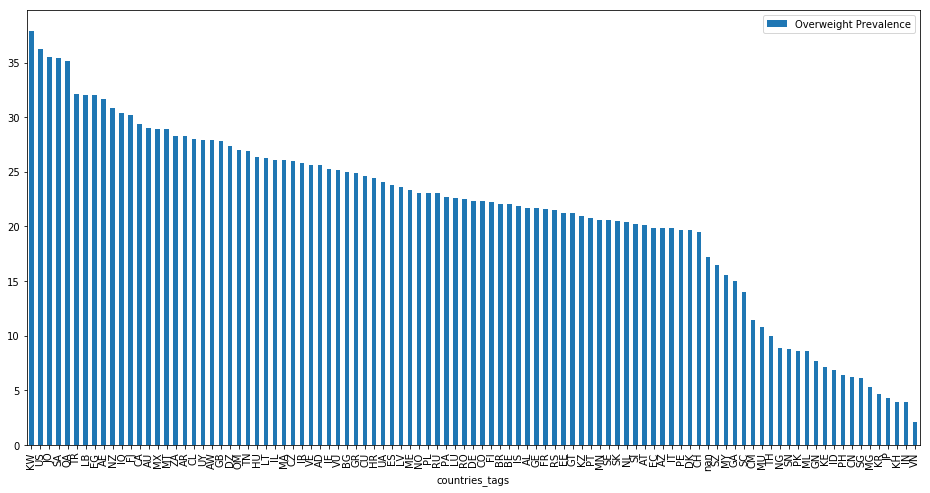

In [56]:
overweight_datas.plot.bar(figsize=(16,8))

### Overweight vs. Fat

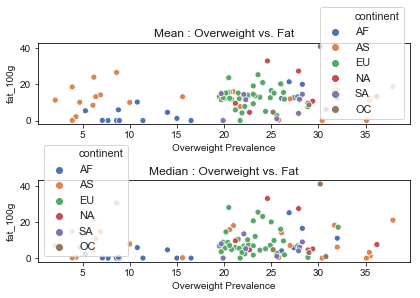

In [57]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 
        'Overweight Prevalence', 'fat_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Fat')

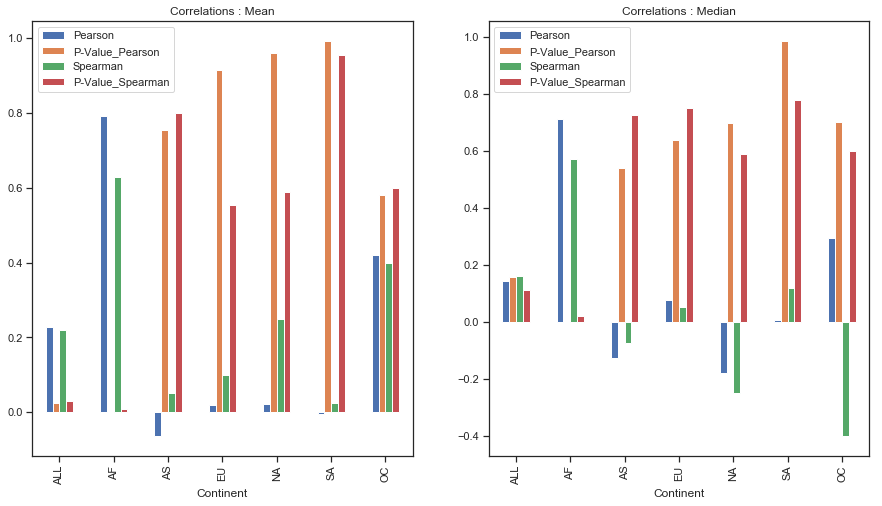

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.228959         0.023347  0.220379          0.029218
1        AF  0.790805         0.000265  0.629921          0.008916
2        AS -0.064185         0.755416  0.052326          0.799603
3        EU  0.018124         0.915210  0.100545          0.553780
4        NA  0.023019         0.960933  0.250000          0.588724
5        SA -0.003835         0.992810  0.023810          0.955374
6        OC  0.419571         0.580429  0.400000          0.600000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.144080         0.156946  0.161366          0.112430
1        AF  0.711828         0.001981  0.570765          0.020942
2        AS -0.126092         0.539360 -0.072198          0.725968
3        EU  0.079373         0.640517  0.054192          0.750063
4        NA -0.179897         0.699514 -0.250000          0.588724
5        SA  0.006895         0.987072  0.119048          0.778886
6        OC  0.296655         0.703345 -0.400000          0.600000

In [58]:
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'fat_100g', 'Mean', 'Median', columns, continent)

### Overweight vs. Sugar


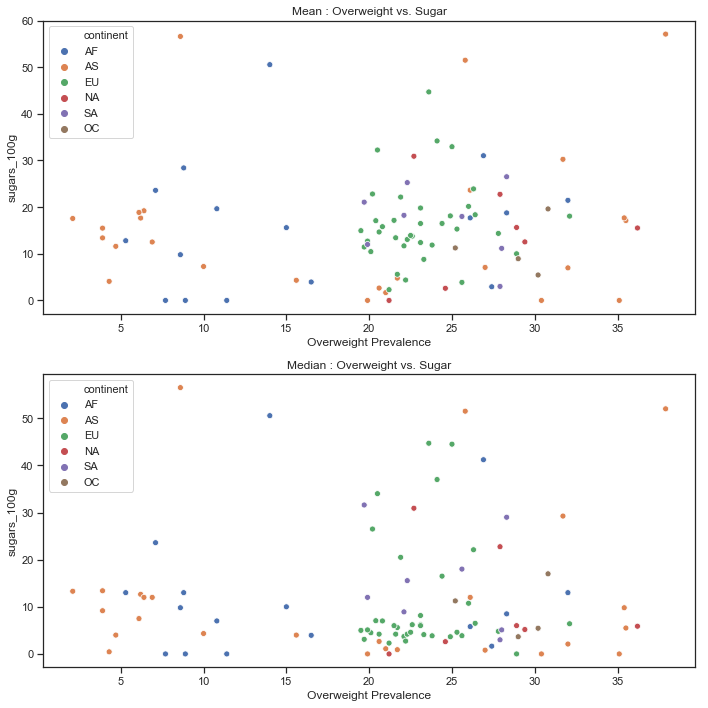

In [59]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 'Overweight Prevalence', 'sugars_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Sugar')

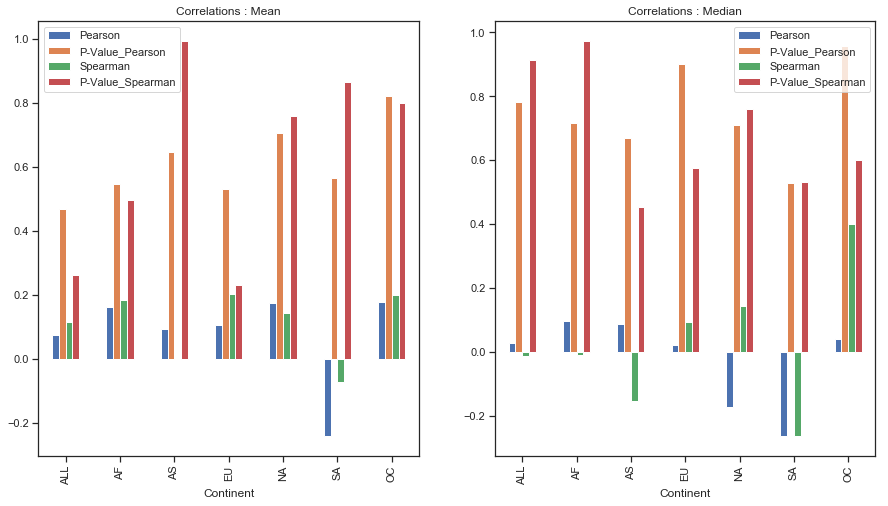

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.074221         0.467641  0.114176          0.262947
1        AF  0.162509         0.547623  0.182892          0.497786
2        AS  0.094420         0.646378 -0.001369          0.994705
3        EU  0.106353         0.530990  0.202039          0.230454
4        NA  0.174831         0.707713  0.142857          0.759945
5        SA -0.241663         0.564214 -0.071429          0.866526
6        OC  0.179320         0.820680  0.200000          0.800000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.028297         0.782097 -0.010894          0.915213
1        AF  0.098019         0.717993 -0.008876          0.973974
2        AS  0.087488         0.670851 -0.153767          0.453268
3        EU  0.021377         0.900061  0.094656          0.577347
4        NA -0.172829         0.710959  0.142857          0.759945
5        SA -0.263278         0.528691 -0.261905          0.530923
6        OC  0.040760         0.959240  0.400000          0.600000

In [60]:
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'sugars_100g', 'Mean', 'Median', columns, continent)

Weirdly enough, there is no correlation for the countries with the fattiest/most sugary foods and their overweight prevalence. 
#### Linear Regression

In [61]:
def lin_reg(df, label):
    X = df.drop(label, axis=1)
    y = df[label]
    lr = LinearRegression()
    lr.fit(X, y)
    print("estimated intercept coefficients: ", lr.intercept_, " number of coefficients: ", len(lr.coef_))
    a = pd.DataFrame(columns=['features', 'estimatedCoefficients'])
    a['features'] = X.columns
    a['estimatedCoefficients'] = lr.coef_
    display(a)

In [62]:
lin_reg(mean_overweight[0], 'Overweight Prevalence')

estimated intercept coefficients:  15.994436161724465  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g               0.019689
1            fat_100g               0.649200
2         energy_100g               0.000040
3  carbohydrates_100g               0.065019
4       proteins_100g               0.213970
5           salt_100g           -1845.143413
6         sodium_100g            4685.150966
7  saturated-fat_100g              -1.166868
8          fiber_100g              -0.073514

In [63]:
lin_reg(median_overweight[0], 'Overweight Prevalence')

estimated intercept coefficients:  17.618591529143472  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g              -0.003091
1            fat_100g               0.249854
2         energy_100g               0.002859
3  carbohydrates_100g              -0.015915
4       proteins_100g               0.170452
5           salt_100g            4259.758192
6         sodium_100g          -10823.029340
7  saturated-fat_100g              -0.699667
8          fiber_100g               0.444879

Something seems to be happening for salt and sodium. Let's check.

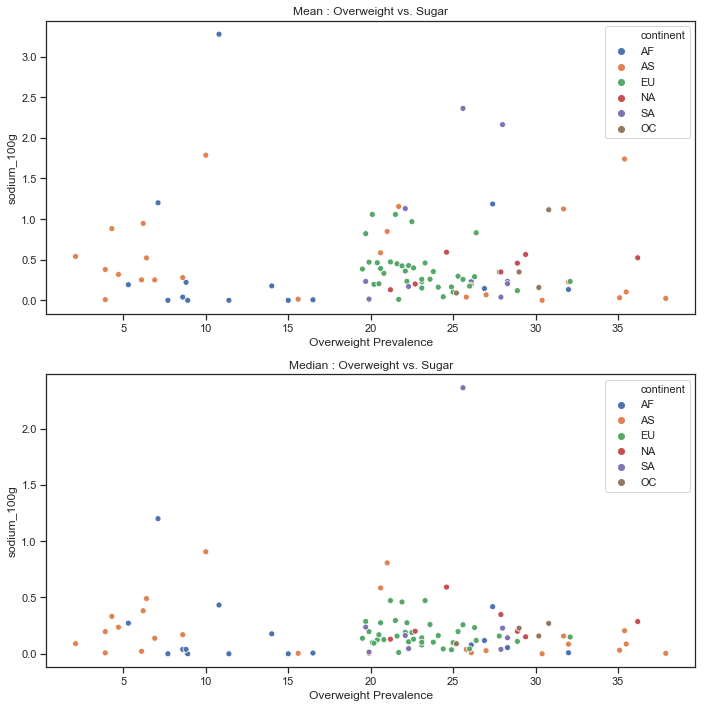

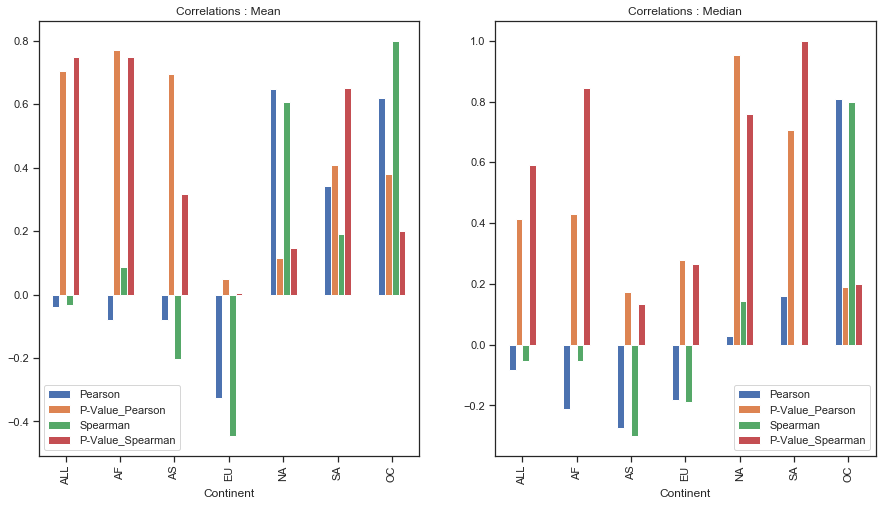

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.038918         0.703596 -0.032861          0.748044
1        AF -0.079060         0.771019  0.087410          0.747533
2        AS -0.080992         0.694086 -0.204479          0.316341
3        EU -0.327702         0.047707 -0.446526          0.005600
4        NA  0.647169         0.116126  0.607143          0.148231
5        SA  0.341692         0.407448  0.190476          0.651401
6        OC  0.618809         0.381191  0.800000          0.200000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.083465         0.413878 -0.055115          0.589872
1        AF -0.211901         0.430779 -0.053375          0.844361
2        AS -0.275609         0.172949 -0.301300          0.134710
3        EU -0.182974         0.278379 -0.187370          0.266792
4        NA  0.027260         0.953740  0.142857          0.759945
5        SA  0.159957         0.705158  0.000000          1.000000
6        OC  0.809304         0.190696  0.800000          0.200000

In [64]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 'Overweight Prevalence', 'sodium_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Sugar')
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'sodium_100g', 'Mean', 'Median', columns, continent)

Slight/Moderate correlation between sodium_100g and overweight for Europe. 

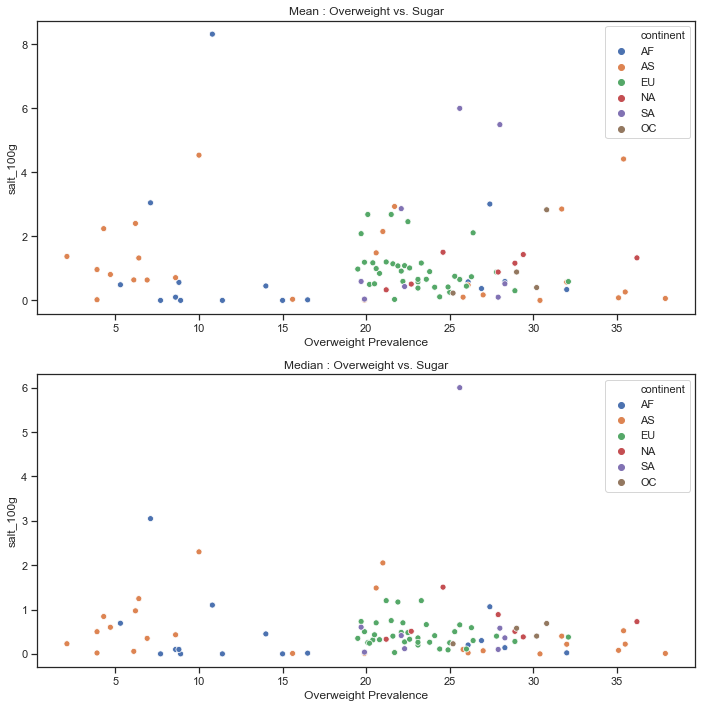

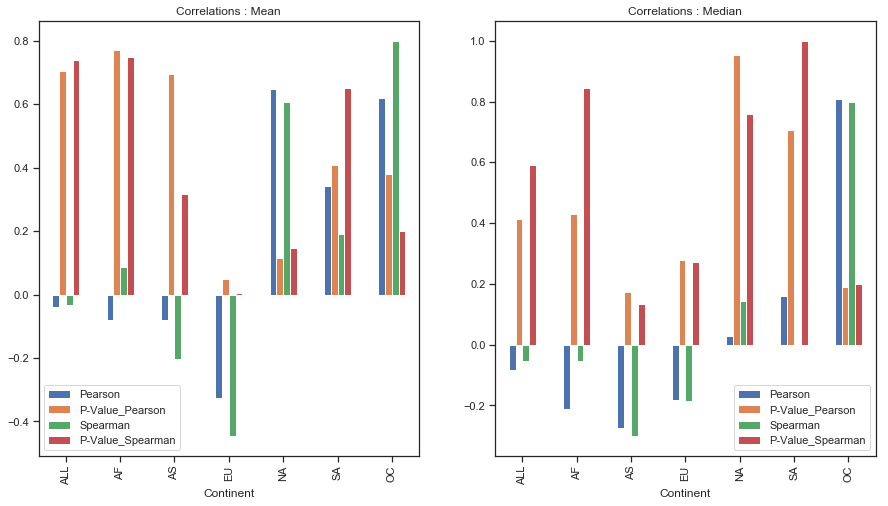

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.038941         0.703429 -0.033824          0.740919
1        AF -0.079061         0.771015  0.087410          0.747533
2        AS -0.081018         0.693994 -0.204479          0.316341
3        EU -0.327746         0.047675 -0.446526          0.005600
4        NA  0.647185         0.116114  0.607143          0.148231
5        SA  0.341737         0.407382  0.190476          0.651401
6        OC  0.618829         0.381171  0.800000          0.200000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.083420         0.414132 -0.054702          0.592670
1        AF -0.211936         0.430703 -0.053375          0.844361
2        AS -0.275488         0.173146 -0.301300          0.134710
3        EU -0.183041         0.278200 -0.184783          0.273571
4        NA  0.027211         0.953823  0.142857          0.759945
5        SA  0.159979         0.705118  0.000000          1.000000
6        OC  0.809416         0.190584  0.800000          0.200000

In [65]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 'Overweight Prevalence', 'salt_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Sugar')
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'salt_100g', 'Mean', 'Median', columns, continent)

As above, there is a slight/moderate correlation between salt_100g and overweight for Europe! 

We might be fooled by oceania, but the number of countries makes the sample way too small to make a conclusion!
Nutriments contents in food don't influence being overweight!

### Diabetes

In [66]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: str(x).lower().replace(' ', '-'))
diab = diab.apply(lambda x: get_tag(x, 'country/territory', 'code'), axis=1)
#remove rows without country codes - we have previously checked that most of them are barely represented in our food data
diab = diab[diab['code'] != 'TBD']
#set index for more agreable plotting
diab.set_index('code', inplace=True)
diab = diab[diab.index.isin(indices)]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab = diab.rename(columns={'Diabetes [18-99] national prevalence[%]':'Diabetes Prevalence'})
diab.index.name = 'countries_tags'

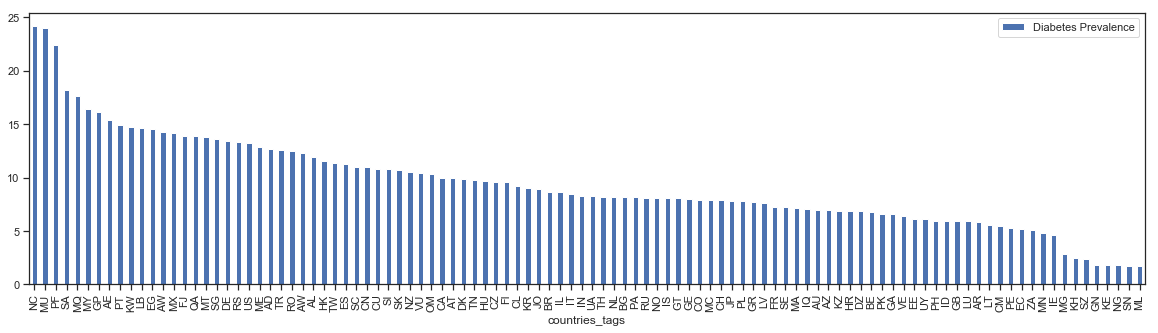

In [67]:
diab.plot.bar(figsize=(20,5))

In [68]:
mean_diabetes = merge_all(means, diab, right_index=True)
median_diabetes = merge_all(medians, diab, right_index=True)

#### Diabetes vs. Fat

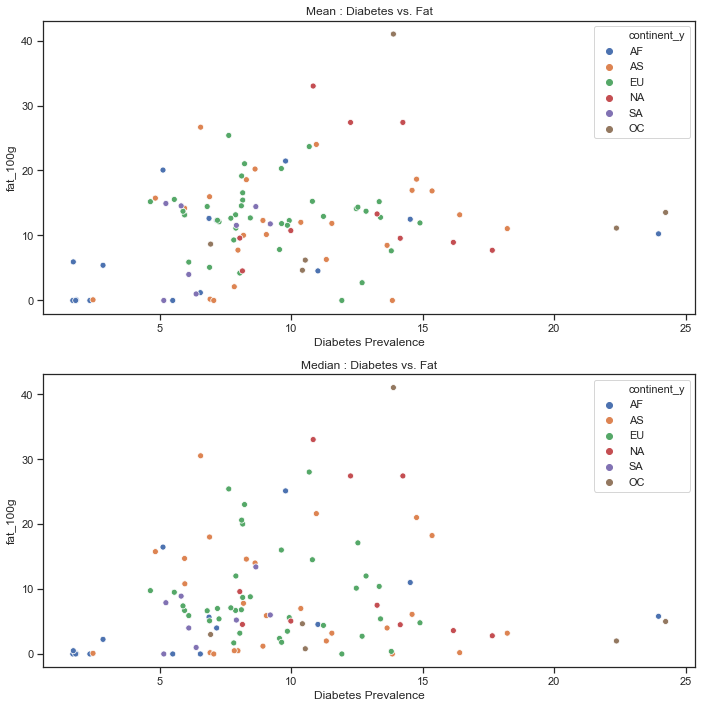

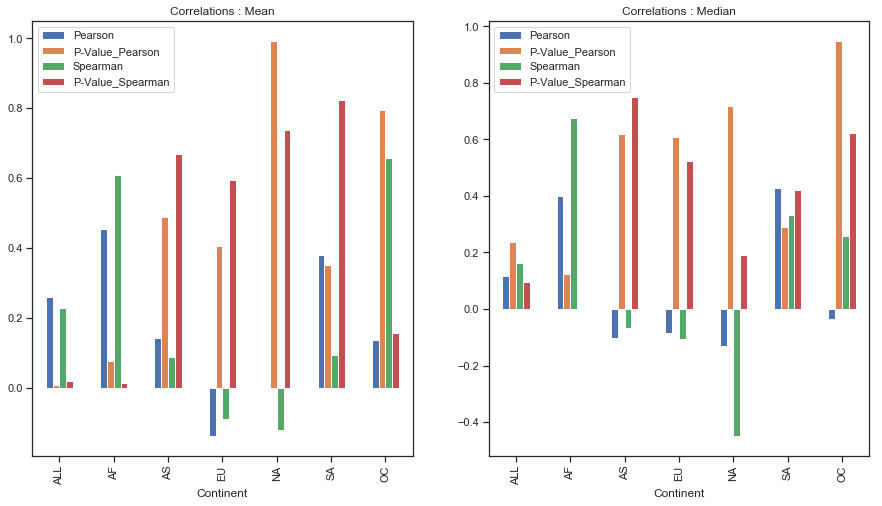

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.259305         0.007859  0.226950          0.020515
1        AF  0.454888         0.076668  0.607978          0.012470
2        AS  0.141700         0.489883  0.087536          0.670680
3        EU -0.138526         0.406869 -0.089402          0.593499
4        NA -0.003066         0.993293 -0.121581          0.737938
5        SA  0.381287         0.351354  0.095238          0.822505
6        OC  0.138002         0.794311  0.657143          0.156175

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.117333         0.235541  0.163793          0.096628
1        AF  0.401445         0.123268  0.676205          0.004028
2        AS -0.102223         0.619254 -0.065686          0.749874
3        EU -0.085709         0.608904 -0.106818          0.523274
4        NA -0.131014         0.718276 -0.449850          0.192076
5        SA  0.427306         0.290986  0.333333          0.419753
6        OC -0.034090         0.948885  0.257143          0.622787

In [69]:
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'fat_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Fat')
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'fat_100g', 
          'Mean', 'Median', columns, continent)

### Diabetes vs. Sugar

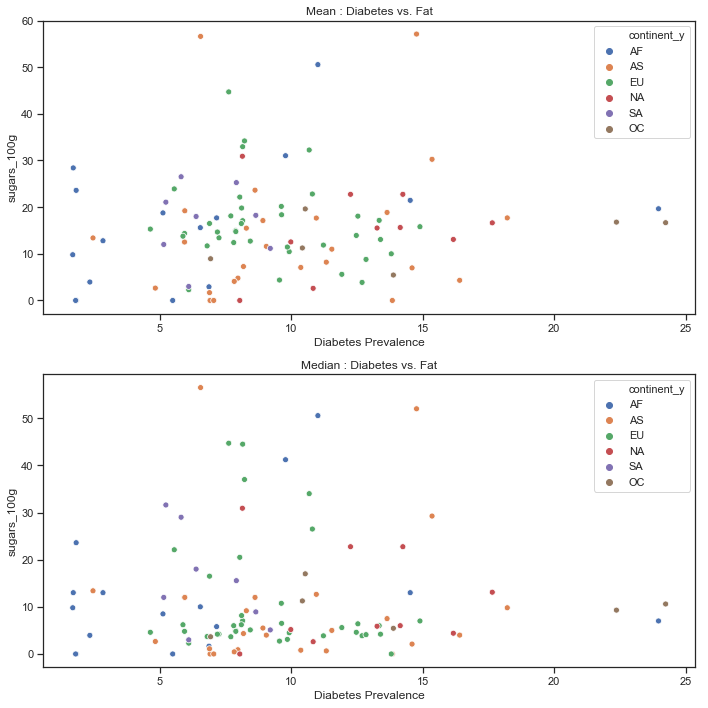

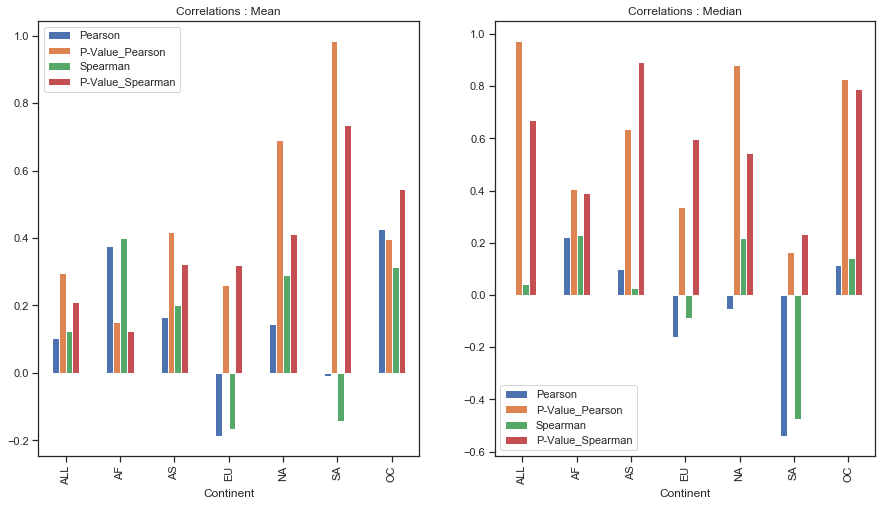

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.103185         0.297250  0.123983          0.209860
1        AF  0.377174         0.149825  0.400001          0.124749
2        AS  0.165528         0.419022  0.201505          0.323583
3        EU -0.187379         0.259950 -0.165892          0.319550
4        NA  0.144894         0.689615  0.291795          0.413327
5        SA -0.008166         0.984690 -0.142857          0.735765
6        OC  0.427456         0.397868  0.314286          0.544093

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.003278         0.973654  0.042033          0.671812
1        AF  0.222935         0.406580  0.230943          0.389481
2        AS  0.097587         0.635314  0.027735          0.893014
3        EU -0.159994         0.337296 -0.088675          0.596519
4        NA -0.055126         0.879777  0.218846          0.543551
5        SA -0.540874         0.166290 -0.476190          0.232936
6        OC  0.114561         0.828910  0.142857          0.787172

In [70]:
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'sugars_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Fat')
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'sugars_100g', 
          'Mean', 'Median', columns, continent)

We see no correlation between diabetes and sugar. 
This may seem quite shocking, but the data we got from the international diabetes federation unfortunately does not differentiate between diabetes type 1 and type 2.

#### Linear Regression

In [71]:
lin_reg(mean_diabetes[0].drop(columns=['country/territory','alpha3', 'continent']), 'Diabetes Prevalence')
lin_reg(median_diabetes[0].drop(columns=['country/territory','alpha3', 'continent']), 'Diabetes Prevalence')

estimated intercept coefficients:  6.100054735806637  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g               0.003806
1            fat_100g               0.267271
2         energy_100g               0.000299
3  carbohydrates_100g               0.024654
4       proteins_100g              -0.041276
5           salt_100g            1646.485648
6         sodium_100g           -4180.249881
7  saturated-fat_100g              -0.359701
8          fiber_100g               0.021950

estimated intercept coefficients:  7.671714644646833  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g              -0.042354
1            fat_100g              -0.033097
2         energy_100g               0.001560
3  carbohydrates_100g               0.005925
4       proteins_100g               0.234795
5           salt_100g             -34.311051
6         sodium_100g              84.674420
7  saturated-fat_100g               0.007373
8          fiber_100g              -0.169408

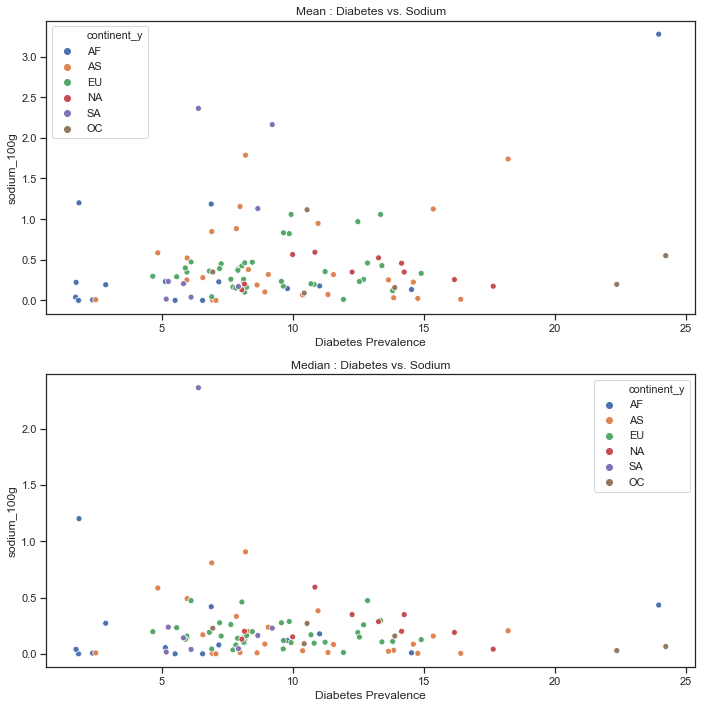

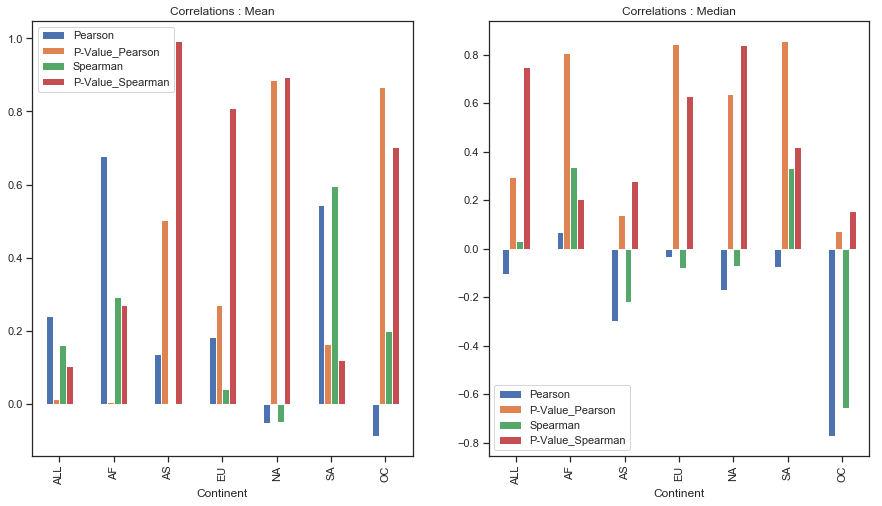

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.241195         0.013644  0.160190          0.104294
1        AF  0.678696         0.003845  0.292816          0.271070
2        AS  0.137419         0.503223 -0.001709          0.993388
3        EU  0.183744         0.269477  0.040379          0.809793
4        NA -0.051547         0.887540 -0.048632          0.893868
5        SA  0.543526         0.163811  0.595238          0.119530
6        OC -0.088252         0.867966  0.200000          0.704000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.103421         0.296137  0.031893          0.747909
1        AF  0.066257         0.807388  0.334579          0.205282
2        AS -0.299152         0.137649 -0.220551          0.278949
3        EU -0.033568         0.841427 -0.080552          0.630695
4        NA -0.171324         0.636036 -0.072949          0.841271
5        SA -0.076781         0.856600  0.333333          0.419753
6        OC -0.773746         0.070995 -0.657143          0.156175

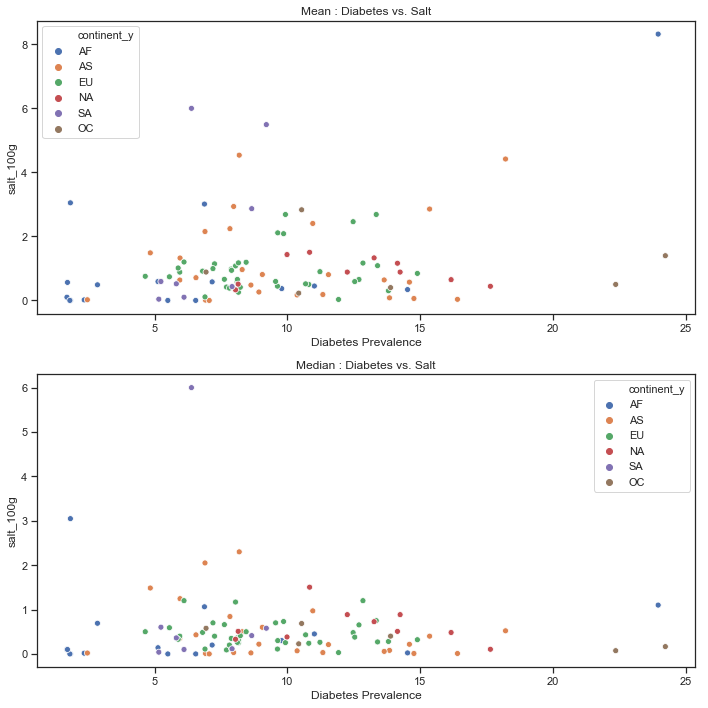

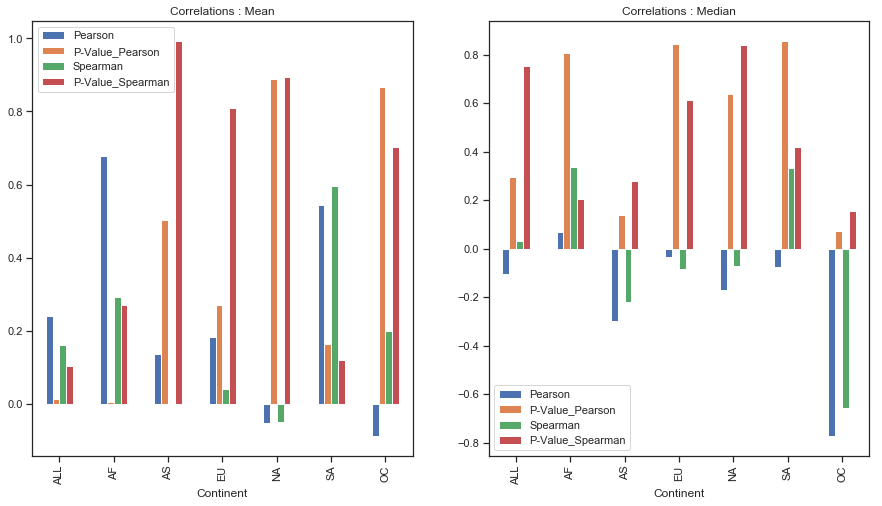

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL  0.241217         0.013634  0.159971          0.104774
1        AF  0.678697         0.003845  0.292816          0.271070
2        AS  0.137473         0.503052 -0.001709          0.993388
3        EU  0.183719         0.269540  0.040379          0.809793
4        NA -0.051497         0.887649 -0.048632          0.893868
5        SA  0.543429         0.163901  0.595238          0.119530
6        OC -0.088246         0.867975  0.200000          0.704000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.103411         0.296185  0.031240          0.752904
1        AF  0.066257         0.807388  0.334579          0.205282
2        AS -0.299113         0.137703 -0.220551          0.278949
3        EU -0.033535         0.841580 -0.084501          0.613979
4        NA -0.171257         0.636171 -0.072949          0.841271
5        SA -0.076795         0.856575  0.333333          0.419753
6        OC -0.773713         0.071015 -0.657143          0.156175

In [72]:
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'sodium_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Sodium')
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'sodium_100g', 
          'Mean', 'Median', columns, continent)
sns_plt(pd.concat(mean_diabetes[1:]),pd.concat(median_diabetes[1:]), 
        'Diabetes Prevalence', 'salt_100g', 'continent_y', 'Mean', 'Median', 'Diabetes vs. Salt')
show_corr(mean_diabetes, median_diabetes, 'Diabetes Prevalence', 'salt_100g', 
          'Mean', 'Median', columns, continent)

We can see some sort of correlation for the mean of salt and sodium for africa (quite strong for the pearson and moderate for the spearman)

### IHD 

In [73]:
ihd_df = ihd.copy()
ihd['IHD'] = ihd['IHD'].apply(lambda x: x*1000)
ihd['Country'] = ihd['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
ihd = ihd.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
ihd = ihd[ihd['code'] != 'TBD']
ihd = ihd.set_index(['code'])

In [74]:
population['Country'] = population['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
population = population.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
population = population[population['code'] != 'TBD']
population = population.set_index(['code'])

In [75]:
pop_ihd = ihd.merge(population, left_index=True, right_index=True)
pop_ihd.drop(columns=['Country_y'], inplace=True)
pop_ihd['IHD_%'] = ""

In [76]:
def find_percentage(row):
    row['IHD_%'] =  row['IHD'] / row['Population'] * 100
    return row

pop_ihd = pop_ihd.apply(find_percentage, axis=1)
pop_ihd.head()

Country_x      IHD alpha3_x continent_x  Population alpha3_y  \
code                                                                            
AE    united-arab-emirates   1200.0      ARE          AS     4444011      ARE   
AL                 albania   5400.0      ALB          EU     3600523      ALB   
AR               argentina  36400.0      ARG          SA    40301927      ARG   
AT                 austria  14600.0      AUT          EU     8199783      AUT   
AU               australia  24900.0      AUS          OC    20434176      AUS   

     continent_y     IHD_%  
code                        
AE            AS  0.027003  
AL            EU  0.149978  
AR            SA  0.090318  
AT            EU  0.178053  
AU            OC  0.121855

#### Linear Regression

In [77]:
mean_ihd = merge_all(means, pop_ihd, right_index=True)
median_ihd = merge_all(medians, pop_ihd, right_index=True)

lin_reg(mean_ihd[0].drop(columns=['IHD', 'Population','Country_x','alpha3_x', 'continent_x', 'alpha3_y', 'continent_y']), 'IHD_%')
lin_reg(median_ihd[0].drop(columns=['IHD', 'Population','Country_x','alpha3_x', 'continent_x', 'alpha3_y', 'continent_y']), 'IHD_%')

estimated intercept coefficients:  0.07122030797187151  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g              -0.000135
1            fat_100g               0.001777
2         energy_100g              -0.000018
3  carbohydrates_100g               0.001206
4       proteins_100g               0.000787
5           salt_100g              19.764513
6         sodium_100g             -50.213404
7  saturated-fat_100g               0.005722
8          fiber_100g              -0.000040

estimated intercept coefficients:  0.08761926740687109  number of coefficients:  9


features  estimatedCoefficients
0         sugars_100g               0.000790
1            fat_100g               0.002573
2         energy_100g               0.000016
3  carbohydrates_100g              -0.000118
4       proteins_100g               0.002837
5           salt_100g             -10.345078
6         sodium_100g              26.254885
7  saturated-fat_100g              -0.000623
8          fiber_100g              -0.002195

The linear regression strongly suggests a correlation with salt and sodium. Let's plot to see:

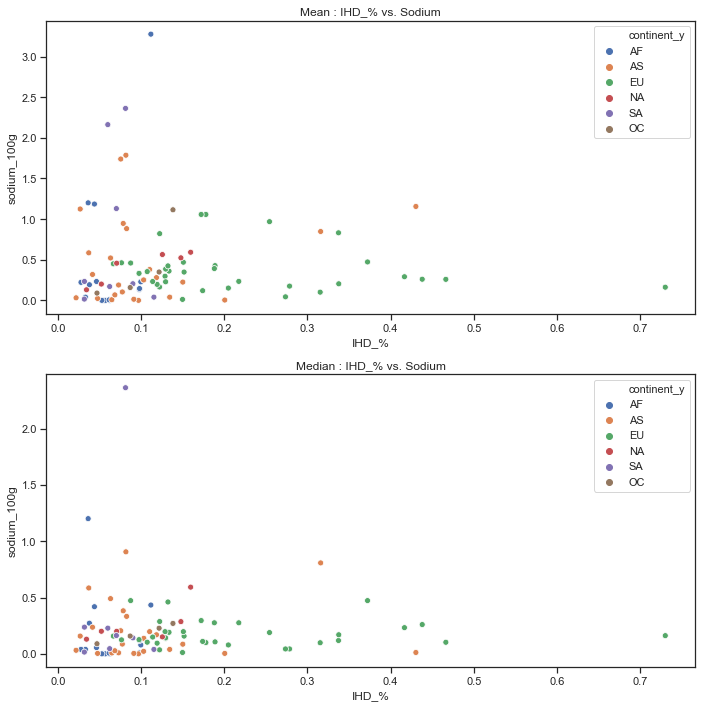

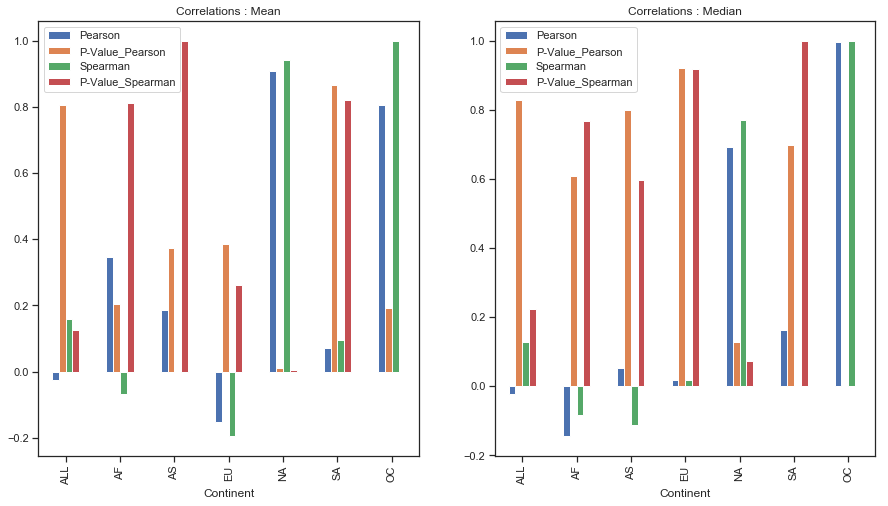

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.025782         0.806218  0.160370          0.124637
1        AF  0.348035         0.203660 -0.066669          0.813378
2        AS  0.185582         0.374456  0.000000          1.000000
3        EU -0.151298         0.385616 -0.194958          0.261731
4        NA  0.907802         0.012359  0.942857          0.004805
5        SA  0.071507         0.866380  0.095238          0.822505
6        OC  0.806104         0.193896  1.000000          0.000000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.022695         0.829040  0.127023          0.225008
1        AF -0.144295         0.607904 -0.082962          0.768803
2        AS  0.053543         0.799348 -0.110791          0.598041
3        EU  0.017065         0.922488  0.017791          0.919203
4        NA  0.693032         0.126882  0.771429          0.072397
5        SA  0.164198         0.697618  0.000000          1.000000
6        OC  0.997346         0.002654  1.000000          0.000000

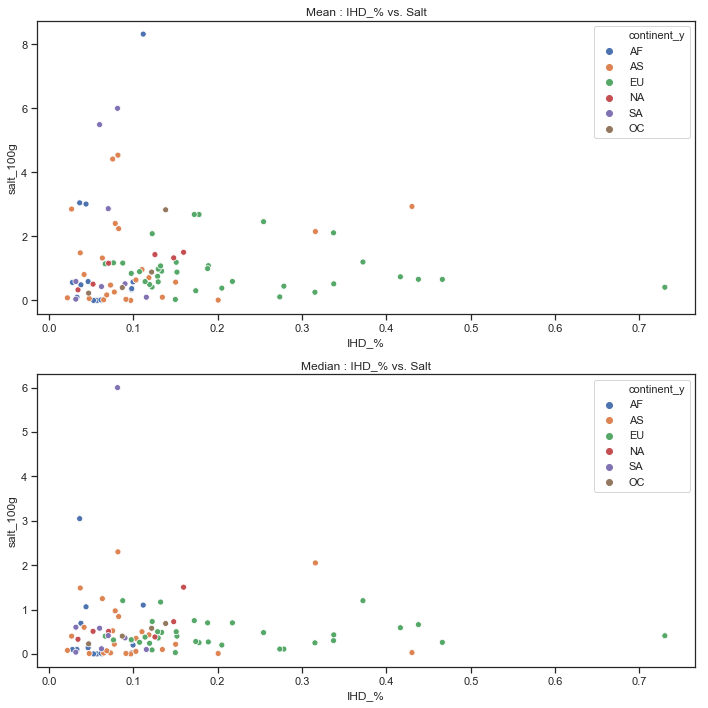

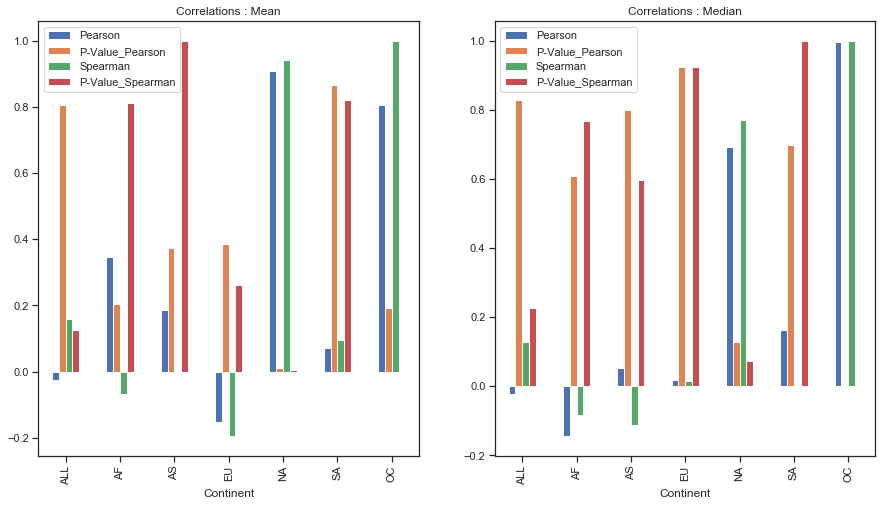

Mean


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.025769         0.806315  0.159848          0.125886
1        AF  0.348039         0.203654 -0.066669          0.813378
2        AS  0.185566         0.374499  0.000000          1.000000
3        EU -0.151250         0.385771 -0.194958          0.261731
4        NA  0.907750         0.012373  0.942857          0.004805
5        SA  0.071470         0.866449  0.095238          0.822505
6        OC  0.806109         0.193891  1.000000          0.000000

Median


Continent   Pearson  P-Value_Pearson  Spearman  P-Value_Spearman
0       ALL -0.022691         0.829074  0.126869          0.225576
1        AF -0.144282         0.607937 -0.082962          0.768803
2        AS  0.053574         0.799234 -0.110791          0.598041
3        EU  0.016999         0.922789  0.016813          0.923632
4        NA  0.692913         0.126974  0.771429          0.072397
5        SA  0.164214         0.697590  0.000000          1.000000
6        OC  0.997355         0.002645  1.000000          0.000000

In [91]:
sns_plt(pd.concat(mean_ihd[1:]),pd.concat(median_ihd[1:]), 
        'IHD_%', 'sodium_100g', 'continent_y', 'Mean', 'Median', 'IHD_% vs. Sodium')
show_corr(mean_ihd, median_ihd, 'IHD_%', 'sodium_100g', 
          'Mean', 'Median', columns, continent)
sns_plt(pd.concat(mean_ihd[1:]),pd.concat(median_ihd[1:]), 
        'IHD_%', 'salt_100g', 'continent_y', 'Mean', 'Median', 'IHD_% vs. Salt')
show_corr(mean_ihd, median_ihd, 'IHD_%', 'salt_100g', 
          'Mean', 'Median', columns, continent)

Sodium_100g: Mean
North America, 0.907802, 0.012359, 0.942857, 0.004805

Salt_100g: Mean
North America, 0.907750, 0.012373, 0.942857, 0.004805

For north america ,we can see a very strong correlation between the sodium and salt quantity in foods with respect to deaths by heart attacks. 
Let's plot just for north america:



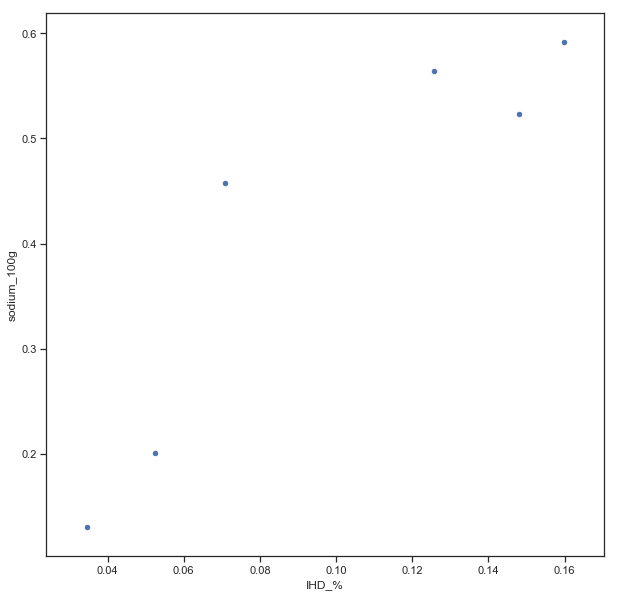

In [79]:
mean_ihd[4].plot.scatter('IHD_%', 'sodium_100g')

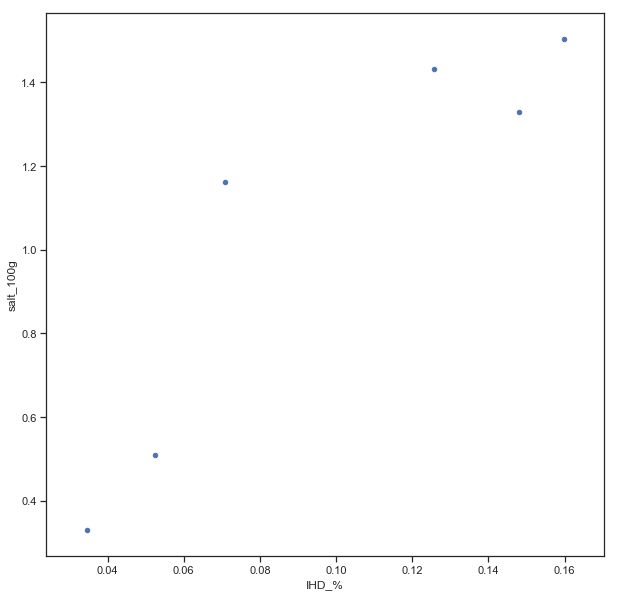

In [80]:
mean_ihd[4].plot.scatter('IHD_%', 'salt_100g')


We see that the correlation is strong, though we don't have many countries to represent it. Although it fits the common knowledge that salt influences heart attacks. 

### Visualization

In [81]:
def from_2_to_3_country_code(country_tag_2):
    code = countries_infos[countries_infos['COUNTRY_ALPHA2_CODE'] == country_tag_2]['COUNTRY_ALPHA3_CODE'].drop_duplicates()
    if code.size != 1:
        return 'TBD'
    else:
        return code.iloc[0]

In [82]:
def get_code_from_json(json_object):
    found = re.search('.id.\s*:\s*.(\w\w\w).', json_object, re.IGNORECASE)  
    #print(json_object)
    if found:
        json_object = found.group(1)
    return json_object

In [83]:
def get_map(data, values_name, countries='countries_tags'):
    data_for_map = data.reset_index()
    data_for_map[countries] = data_for_map[countries].apply(lambda x: from_2_to_3_country_code(x))
    
    countries_shapes['features'] = countries_shapes['features'].apply(lambda x: get_code_from_json(str(x)))

    for code in countries_shapes['features']:
        if len(code) != 3:
            continue

        if data_for_map[data_for_map[countries] == code].size == 0:
            test = pd.DataFrame(columns=['data_for_map', values_name])
            
            dTest = {
                countries : code,
                values_name : 0
            }
            
            data_for_map = data_for_map.append(dTest, ignore_index=True)
            
        
            
    # Setup a folium map at a high-level zoom
    map = folium.Map(location=[30, 0], zoom_start=2)

    # choropleth maps bind Pandas Data Frames and json geometries.
    #This allows us to quickly visualize data combinations
    map.choropleth(geo_data=DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, data=data_for_map,
                 columns=[countries, values_name],
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name=values_name)
    return map

In [84]:
sugar_map = get_map(mean['sugars_100g'], 'sugars_100g')
sugar_map.save('sugar_map.html')
sugar_map

[See the sugar map here](sugar_map.html)

In [85]:
fat_map = get_map(mean['fat_100g'], 'fat_100g')
fat_map.save('fat_map.html')
fat_map

[See the fat map here](fat_map.html)

In [87]:
ow_data = get_map(overweight_datas, 'Overweight Prevalence')
ow_data.save('ow_map.html')
ow_data

[See the overweight map here](ow_map.html)

In [88]:
prot_map = get_map(mean[['proteins_100g']], 'proteins_100g')
prot_map.save('prot_map.html')
prot_map

[See the protein map here](prot_map.html)

In [89]:
diab_map = get_map(diab[['Diabetes Prevalence']], 'Diabetes Prevalence')
diab_map.save('diab_map.html')
diab_map

[See the diabetes map here](diabetes_map.html)

In [90]:
ihd_map = get_map(pop_ihd[['IHD_%']], 'IHD_%', countries='code')
ihd_map.save('ihd_map.html')
ihd_map

[See the IHD map here](ihd_map.html)